In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Cvičení 3: Iterační metody pro řešení lineárních algebraických systémů

---
- [poznámky z přednášky](https://www.karlin.mff.cuni.cz/~blechta/znm/assets/Reseni_soustav.pdf)
- další materiály
  - kniha [Duintjer Tebbens a kolektiv: Analýza metod pro maticové výpočty](https://cuni.primo.exlibrisgroup.com/discovery/fulldisplay?docid=alma990020832750106986&context=L&vid=420CKIS_INST:UKAZ&lang=cs&search_scope=MyInst_and_CI&adaptor=Local%20Search%20Engine&tab=Everything&query=any,contains,Anal%C3%BDza%20metod%20pro%20maticov%C3%A9%20v%C3%BDpo%C4%8Dty&offset=0)  (Sekce 9.1)
  - kniha [Y. Saad: Iterative Methods for Sparse Linear Systems](https://www-users.cse.umn.edu/~saad/IterMethBook_2ndEd.pdf) (Kapitola 4; bible oboru)
  - skripta [Foundations of Applied Mathematics](https://foundations-of-applied-mathematics.github.io/) (Volume 1, Kapitola 15)

- ***Primární úlohy*** : A1, A2, B1

- ***Úlohy k bonusové části zkoušky*** : A1, A2

- základní ***Learning outcomes*** (cviko, nikoliv přednáška)
  - Umím pro dané štěpení matice $A$ odvodit podmínky na konvergenci odpovídající stacionární metody.
  - Z grafů v lineárním, semilogaritmickém i logaritmickém (na obou osách) měřítku určím asymptotický řád konvergence.
  - Umím vysvětlit rozdíl v konvergenci stacionárních metod pro případ, kdy je iterační matice symetrická a kdy diagonalizovatelná, ale nikoliv pomocí unitární transformace.
  - Pro danou stacionární metodu dokážu odvodit její formulaci jako polynomiální metody.

---

## Intro

První, klasický způsob řešení

$$ A\mathbf{x} = \mathbf{b} \qquad (\star) $$

jsme už částečně potkali v minulém cviku - Gaussova eliminace s částečnou pivotací (nebo ekvivalentně LU rozklad a odpovídající problémy s trojúhelníkovými maticemi). Dvě hlavní nevýhody jsou

> Nemůžeme jednoduše ovlivnit přesnost řešení:
  - v mnoha (téměř ve většině) aplikacích máme data z reálného měření/simulací, které jsou sami o sobě zatéžené nějakou chybou - většinou výrazně vyšší než $\varepsilon_{mach}$. Pokud víme, že $A$ a $\mathbf{b}$ jsou zatíženy chybou řádu $\delta \gg \varepsilon_{mach}$, dává smysl se ptát na řešení splňující $(\star)$ pouze na úrovni $\delta$ - například můžeme hledat $\mathbf{x}_{\delta}$ takové, že platí pouze
  $$ \| \underbrace{ \mathbf{b} - A \mathbf{x}_{\delta} }_{=: \, \mathbf{r}_{\delta} \, \leftarrow \, \mathrm{ tzv. \; reziduum}} \| \approx \delta. $$
  Gaussova eliminace nám nic takového sama o sobě neumožňuje a tedy musíme "ztrácet čas" výpočtem $\mathbf{x}$ v přesnosti $\varepsilon_{mach}$. Jednou možností jak umožnit "kontrolu přesnosti řešení" v průběhu výpočtu jsou iterační metody.
  - alternativní formulace téhle nevýhody je, že nejsme schopni kontrolovat čas výpočtu. Pokud víme, že máme na výpočet pouze několik vteřin/minut, protože pak už je výsledek bezcenný (např. předpověď počasí, trading na burzách, ...) a náš odhad časové náročnosti Gaussovy eliminace
  $$\# \,\mathrm{flops} \sim \frac{2}{3}n^3 + \mathcal{O}(n^2)$$
  predikuje, že řešení $(\star)$ bude trvat déle, pak zjevně potřebujeme jiný postup. Jednou možností jsou iterační metody.

> Nemáme safety-points:
  - podle věty o stabilitě LU rozkladu s částečnou pivotací (a tedy Gaussovy eliminace) můžeme stabilitu výpočtu monitorovat v průběhu samotného výpočtu - stačí kontrolovat velikosti prvků v již spočtených částech matic $L$ a $U$ (v porovnání s velikostmi prvků $A$). Ovšem v minulém cvičení jsme viděli, že na problém můžeme narazit až u konce tohoto procesu - pro Wilkinsonovy matice $W_n$ nám stabilita exponenciálně klesala s počtem kroků, které už jsme v procesu LU-rozkladu udělali.
  - Může se tedy stát, že po hodinách a hodinách výpočtu stabilitu "úplně ztratíme" (tj. až po těch hodinách výpočtu uvidíme, že námi vypočtený LZ-rozklad není dostatečně stabilní) a musíme začít opět úplně od začátku. Nemáme žádné "přibližné řešení", nic čím bychom mohli ty hodiny výpočtu "obhájit". Přirozenou možností jak toto napravit jsou iterační metody.


Přímé metody pro řešení $(\star)$ (jako například LU rozklad, ale uvidíme v průběhu první půlky semestru i další), po nějaké době výpočtu, vydají jedno numerické řešení. Myšlenka iteračních metod je principálně odlišná, spočívá v konstrukci *posloupnosti aproximací* (přibližných řešení) $\mathbf{x}_0, \mathbf{x}_1, \mathbf{x}_2, \ldots $, která by se měla přibližovat skutečnému řešení $\mathbf{x}$.

## Část A: Klasické iterační metody (aka [stacionární](https://en.wikipedia.org/wiki/Iterative_method#Stationary_iterative_methods))

Klasické iterační metody jsou založeny na štěpení matice soustavy $A = M-N$, kde matice $M$ je regulární a snadno invertovatelná. Dosazením do vztahu $A\mathbf{x}=\mathbf{b}$ postupně dostáváme
\begin{eqnarray*}
    (M-N)\mathbf{x} &=& \mathbf{b} \\
    M\mathbf{x} &=& N\mathbf{x} + \mathbf{b} \\
    \mathbf{x} &=& M^{-1}N\mathbf{x} + M^{-1}\mathbf{b}.
\end{eqnarray*}

Máme-li počáteční aproximaci řešení $\mathbf{x}_0$, pak můžeme nastartovat iterační proces
$$ \mathbf{x}_k = M^{-1}N \mathbf{x}_{k-1} + M^{-1}\mathbf{b}. $$

Ty základní klasické iterační metody jsou založeny na štěpení ve tvaru

$$
A =
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\underbrace{ \begin{bmatrix}
a_{1,1} & 0 & \cdots & 0 \\
0 & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & 0 \\
0 & \cdots & 0 & a_{n,n} \\
\end{bmatrix} }_{=: \, D} -
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\underbrace{ \begin{bmatrix}
0 & 0 & \cdots & 0 \\
-a_{2,1} & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & 0 \\
-a_{n,1} & \cdots & -a_{n,n-1} & 0 \\
\end{bmatrix} }_{=: \, L} -
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\underbrace{ \begin{bmatrix}
0 & -a_{1,2} & \cdots & -a_{1,n} \\
0 & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & -a_{n-1,n} \\
0 & \cdots & 0 & 0 \\
\end{bmatrix} }_{=: \, U}$$

kde $D$ je hlavní diagonála, $-L$ je striktně dolní trojúhelník matice $A$ a $-U$ je striktně horní trojúhelník matice $A$.

- V [Jacobiho metodě](https://en.wikipedia.org/wiki/Jacobi_method) volíme $M=D$, $N = L+U$, a je tedy definována iterací
$$D \mathbf{x}_{k} = (L + U)\mathbf{x}_{k-1} +\mathbf{b},$$

- [Gaussova-Seidelova metoda](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method) používá $M=D-L$, $N = U$ a je definována jako
$$ (D-L) \mathbf{x}_{k} = U \mathbf{x}_{k-1} +\mathbf{b}.$$


- Další metodou, která je užitečná víceméně pouze jako teoretický nástroj je [Richardsonova metoda](https://en.wikipedia.org/wiki/Modified_Richardson_iteration), která odpovídá volbě $M=I$, $N = I-A$, a je tedy definována iterací
$$ \mathbf{x}_{k} = (I-A)\mathbf{x}_{k-1} +\mathbf{b} = \mathbf{x}_{k-1} + (\mathbf{b} - A\mathbf{x}_{k-1}).$$




Pro analýzu klasických iteračních metod je důležitý vztah mezi chybami dvou následujících přibližných řešení, tj. mezi $\mathbf{e}_{k} :=\mathbf{x} - \mathbf{x}_{k}$ a $\mathbf{e}_{k-1} := \mathbf{x}_{k} - \mathbf{x}_{k-1}$:

$$
\mathbf{e}_{k} = M^{-1}N \mathbf{e}_{k-1} = (I - M^{-1}A) \mathbf{e}_{k-1}  = \cdots = (I - M^{-1}A)^k \mathbf{e}_{0},
$$

který jsme viděli na přednášce. Říká nám, že pokud chceme aby chyba $\mathbf{e}_{k} = \mathbf{x} - \mathbf{x}_{k}$ konvergovala k $\mathbf{0}$ pro libovolné $\mathbf{x}_{0}$, pak nutně musí platit

$$ (I - M^{-1}A)^k \longrightarrow 0 \qquad \mathrm{pro} \; k\rightarrow +\infty. $$

Opět z přednášky víme, že

$$ (I - M^{-1}A)^k \longrightarrow 0 \quad \mathrm{pro} \; k\rightarrow +\infty  \quad \iff \quad \underbrace{ \left( \max\limits_{\lambda \, \mathrm{je \, vl. \, cislo \,} I - M^{-1}A }  \, |\lambda| \right) }_{=: \, \rho(I - M^{-1}A) }  \; < 1. \qquad (\star \star)$$

Pokud jde o měření rychlosti konvergence stacionárních metod, říkáme, že konvergují ***lineárně*** s konevrgenčním faktorem $\rho < 1$, pokud platí

$$ \lim\limits_{k \rightarrow +\infty}  \frac{ \| \mathbf{e}_{k} \| }{ \| \mathbf{e}_{k-1} \| } = \rho. \qquad (\Delta)$$


### Úloha A1 - implementace & konvergence


---
**Kódění**: Naimplementujte funkce `JacobihoMetoda()` a `GaussSeidelMetoda()`, podle anotací níže.


**Tužka a papír**:

  - Vezměmě si obecnou stacionární metodu založenou na štěpení $A = M-N$ (kde $M$ je regulární). Předpokládejme, že matice $I - M^{-1}A$ je unitárně diagonalizovatelná a má vlastní vektory $\mathbf{u}_1,\dotsc , \mathbf{u}_n$ příslušné vlastním číslům $\lambda_1,\dotsc  ,\lambda_n$ (ne ne nutně seřazené podle velikosti absolutní hodnoty).

    - Odvoďte velikost konvergenčního faktoru $\rho$.
    <details>
    <summary>Chci <font color="red"><b>hint</b></font></summary>
    Spočtěte si $(X \Lambda X^{-1})^2.$
    </details>

    - Odvoďte konvergenční podmínky v případě, že $\mathbf{x}_0 \in \mathrm{span} \left( \mathbf{u}_1,\dotsc , \mathbf{u}_k \right)$ pro nějaké $k\ll n$. Jak se změní konvergenční faktor?

    - Rozhodněte, zda konvergence musí být monotóní čí nikoliv.

  - Co se změní, pokud $I - M^{-1}A$ není unitárně diagonalizovatelná, ale pouze diagonalizovatelná? Jak bude vypadat konvergenční faktor? Rozhodněte, zda konvergence musí být monotóní čí nikoliv.

  - <summary>Chci <font color="red"><b>hint 1</b></font></summary> <details>
  Vezměme si diagonalizovatelnou matici $X$, která není unitárně diagonalizovatelná. Co umíme (jestli vůbec něco) říct o souvislosti
  $$ \| X \|_2 := \max\limits_{\|\mathbf{v}\|=1} \|X\mathbf{v}\| \qquad \mathrm{a} \qquad \rho(X) := \max\limits_{\lambda \, \mathrm{je\, vl.\, c. \,} X} |\lambda |. $$
  </details>

  
  - <summary>Chci <font color="red"><b>hint 2</b></font></summary> <details>
  Může nastat
  $$ \| X \|_2 := \max\limits_{\|\mathbf{v}\|=1} \|X\mathbf{v}\| > 1 > \rho(X) := \max\limits_{\lambda \, \mathrm{je\, vl.\, c. \,} X} |\lambda |? $$
  Co nám to říká o možné velikosti $\| \mathbf{e}_1\|_2 = \| (I - M^{-1}A) \mathbf{e}_0\|_2$? Zkuste experimentovat s maticí
  $ \begin{bmatrix} 0 & \alpha \\0 & 0\end{bmatrix}. $
  </details>

  - Co se změní, pokud $I - M^{-1}A$ není diagonalizovatelná, ale pouze jordanizovatelná? Jak bude vypadat konvergenční faktor? Rozhodněte, zda konvergence musí být monotóní čí nikoliv.

----

In [ ]:
def JacobihoMetoda(A,b,x0, nmb_iter):
  '''
  Implementace Jacobiho metody pro reseni "Ax=b", ktera provede "nmb_iter" iteraci s  pocatecnim odhadem "x0".

  Input
  -------
  A :  np.array dimenze "n-krat-n"s prvky np.float64. matice soustavy (*). Predpokladame, A je regularni a ze diagonalni prvky jsou nenulove.
  b :  np.array dimenze "n" s prvky np.float64. prava strana soustavy (*)
  x0 :  np.array dimenze "n" s prvky np.float64. pocatecni odhad na reseni soustavy (*)
  nmb_iter :  np.int32. Pocet iteraci algoritmu, max_iter > 0

  Output
  -------
  MojeAproximace : np.array dimenze "(nmb_iter+1)-krat-n". Musi platit "AproximaceKorene[i,:] = xi", kde "xi" je i-ta aproximace (tj. na vystupu vracime celou posloupnost aproximaci, vcetne te nulte)
  '''
  # inicializujeme pole pro ukladani aproximaci reseni, viz output
  MojeAproximace =
  MojeAproximace[0,:] =

  # zkonstruujeme si matice stepeni
  M =
  N =

  # nechame bezet nasi Jacobiho metodu
  for k in range():
    MojeAproximace[k+1,:] =

  # vratime spravny output
  return MojeAproximace


#################################################################### Testovani
def test_JacobihoMetoda():
  x0 = np.array([0,0,0,0]); nmb_iter = 3

  A1 = np.array([ [4,0,0,0] , [0,3,0,0] , [0,0,2,0] , [0,0,0,1] ])
  b1 = np.array([1,1,1,1])
  MojeAproximace1 = JacobihoMetoda(A1,b1,x0, nmb_iter)
  ######################################
  assert MojeAproximace1.shape == (4,4), "Output 'JacobihoMetoda()' pro matici 4-krat-4 a 'nmb_iter = 3' by mel mit rozmery 4-krat-4, ale ma output rozmeru {}".format(MojeAproximace1.shape)
  assert np.linalg.norm(MojeAproximace1[0,:] - x0) < 1e-10, "Podle anotace funkce 'JacobihoMetoda()' by melo platit 'MojeAproximace1[:,0] - x0', ale kod nam vraci \n MojeAproximace1[:,0] = {}  a  x0 = {}".format(MojeAproximace1[:,0], x0)
  assert np.linalg.norm(A1 @ MojeAproximace1[1,:] - b1) < 1e-10, "Pro 'A' diagonalni by mela Jacobiho metoda zkonvergovat v prvni iteraci, ale to se nedeje"

  A2 = np.array([ [3,-1,0,0] , [-1,3,-1,0] , [0,-1,3,-1] , [0,0,-1,3] ])
  b2 = np.array([1,1,1,1])
  MojeAproximace2 = JacobihoMetoda(A2,b2,x0, nmb_iter)
  ######################################
  x1 = np.linalg.solve( np.diag( np.diag(A2) ), b2 )
  assert np.linalg.norm(MojeAproximace2[1,:] - x1) < 1e-10, "Pro 'x0 = 0' by mela Jacobiho metoda v prvni iteraci dat 'x1 = D^{-1} x0', ale to se nedeje"
  x2 = np.linalg.solve( np.diag(np.diag(A2)), (np.diag(np.diag(A2))-A2) @ x1 + b2 )
  assert np.linalg.norm(MojeAproximace2[2,:] - x2) < 1e-10, "Jacobiho metoda nepocita spravne - porad se se cvicicim"

  return "funkce 'JacobihoMetoda()' je OK"
test_JacobihoMetoda()
#################################################################### Testovani

"funkce 'JacobihoMetoda()' je OK"

In [ ]:
def GaussSeidelMetoda(A,b,x0, nmb_iter):
  '''
  Implementace metody Gauss-Seidel pro reseni "Ax=b", ktera provede "nmb_iter" iteraci s  pocatecnim odhadem "x0".

  Input
  -------
  A :  np.array dimenze "n-krat-n"s prvky np.float64. matice soustavy (*). Predpokladame, A je regularni a ze diagonalni prvky jsou nenulove.
  b :  np.array dimenze "n" s prvky np.float64. prava strana soustavy (*)
  x0 :  np.array dimenze "n" s prvky np.float64. pocatecni odhad na reseni soustavy (*)
  nmb_iter :  np.int32. Pocet iteraci algoritmu, max_iter > 0

  Output
  -------
  MojeAproximace : np.array dimenze "(nmb_iter+1)-krat-n". Musi platit "AproximaceKorene[i,:] = xi", kde "xi" je i-ta aproximace (tj. na vystupu vracime celou posloupnost aproximaci, vcetne te nulte)
  '''
  return


#################################################################### Testovani
def test_GaussSeidelMetoda():
  x0 = np.array([0,0,0,0]); nmb_iter = 3

  A1 = np.array([ [4,0,0,0] , [1,3,0,0] , [1,1,2,0] , [1,1,1,1] ])
  b1 = np.array([1,1,1,1])
  MojeAproximace1 = GaussSeidelMetoda(A1,b1,x0, nmb_iter)
  ######################################
  assert MojeAproximace1.shape == (4,4), "Output 'JacobihoMetoda()' pro matici 4-krat-4 a 'nmb_iter = 3' by mel mit rozmery 4-krat-4, ale ma output rozmeru {}".format(MojeAproximace1.shape)
  assert np.linalg.norm(MojeAproximace1[0,:] - x0) < 1e-10, "Podle anotace funkce 'JacobihoMetoda()' by melo platit 'MojeAproximace1[:,0] - x0', ale kod nam vraci \n MojeAproximace1[:,0] = {}  a  x0 = {}".format(MojeAproximace1[:,0], x0)
  assert np.linalg.norm(A1 @ MojeAproximace1[1,:] - b1) < 1e-10, "Pro 'A' dolni trojuhelnikovou by mela metoda Gauss-Seidel zkonvergovat v prvni iteraci, ale to se nedeje"

  A2 = np.array([ [3,-1,0,0] , [-1,3,-1,0] , [0,-1,3,-1] , [0,0,-1,3] ])
  b2 = np.array([1,1,1,1])
  MojeAproximace2 = GaussSeidelMetoda(A2,b2,x0, nmb_iter)
  ######################################
  x1 = np.linalg.solve( np.tril(A2), b2 )
  assert np.linalg.norm(MojeAproximace2[1,:] - x1) < 1e-10, "Pro 'x0 = 0' by mela metoda Gauss-Seidel v prvni iteraci dat 'x1 = D^{-1} x0', ale to se nedeje"
  x2 = np.linalg.solve( np.tril(A2), (np.tril(A2)-A2) @ x1 + b2 )
  assert np.linalg.norm(MojeAproximace2[2,:] - x2) < 1e-10, "Metoda Gauss-Seidel nepocita spravne - porad se se cvicicim"

  return "funkce 'GaussSeidelMetoda()' je OK"
test_JacobihoMetoda()
#################################################################### Testovani

"funkce 'JacobihoMetoda()' je OK"

### Úloha A2 - konvergence a její vykreslování

---
**Tužka a papír**: Velmi často se v numerických výpočtech a experimentech zajímáme o vývoj chyby - výše o velikost $\| \mathbf{e}_k \|$. Při její vizualizaci pak většinou používáme *logaritmické měřítko* - v našem případě to odpovídá vykreslování $\log_{10}( \| \mathbf{e}_k \| ) $ místo $\| \mathbf{e}_k \|$ v závislosti na $k$, viz [plt.semilogy()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.semilogy.html).
  - předpokládejme, že $\| \mathbf{e}_k \| = \rho \| \mathbf{e}_{k-1} \|$ pro $k=1,.2,\dotsc$, tj. že vztah z definice lineární konvergence $(\Delta)$ platí pro všechna $k$, nikoliv pouze limitně. Jak bude vypadat graf $\log_{10}( \| \mathbf{e}_k \| ) $ jako funkce $k$? Vysvětlete proč se konvergenci splňující $(\Delta)$ říká *lineární*.

  - Jak by vypadal graf pokud by byla konvergence
    - ***superlineární***, tj.  
$$ \lim\limits_{k \rightarrow +\infty}  \frac{ \| \mathbf{e}_{k} \| }{ \| \mathbf{e}_{k-1} \| } = 0,$$

    - ***sublineární***, tj.
$$ \forall \rho < 1 \, : \, \lim\limits_{k \rightarrow +\infty}  \frac{ \| \mathbf{e}_{k} \| }{ \| \mathbf{e}_{k-1} \| } > \rho \qquad \mathrm{a} \qquad \lim\limits_{k \rightarrow +\infty} \| \mathbf{e}_{k} \| = 0 .$$

**Tužka a papír**: Výše jsme vykreslovali chybu **v závislosti na počtu iterací** a tedy dává smysl použít *lineární* měřítko na ose $x$. Ale často se stane, že chceme vykreslit vývoj chyby v závislosti na nějakém parametru dané metody/problému - jako například ve druhém cvičení v úloze A1 (obázek níže).
V takovém případě se můžeme ptát ***Kolikrát se zvtěší řád chyby $\|\mathbf{e}_{\theta}\|$ (nebo třeba čísla podmíněnosti matice $A_{\theta}$), když řádově změním velikost parametru $\theta$ ?*** - tedy jak závisí $\log_{10}( \| \mathbf{e}_{\theta} \| ) $ na  $\log_{10}(\theta)$. To odpovídá použití *logaritmického měřítka na obou osách*, viz [plt.loglog()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.loglog.html).

- Vezmeme si dvě posloupnosti
$$0< \theta_1 < \dotsc < \theta_N \quad \mathrm{a}\quad f_1 = f(\theta_1), \dotsc ,f_N=f(\theta_N),$$
pro nějakou nezápornou funkci $f>0$ (tj. $\forall i \, : \, f_i>0$).
  - Dejme tomu, že $f(\theta)=\theta^2$. Jak bude graf bodů $(\theta_i,f_i)_{i=1,\dotsc ,N}$ na grafu s logaritmickým měřítkem na obou osách?
  - Pro jaké funkce $f$ budou body $(\theta_i,f_i)_{i=1,\dotsc ,N}$ ležet příbližně na přímce?
  - Pro jaké funkce $f$ bude graf bodů $(\theta_i,f_i)_{i=1,\dotsc ,N}$ ležet na přímce $a\cdot \theta + b$?
----

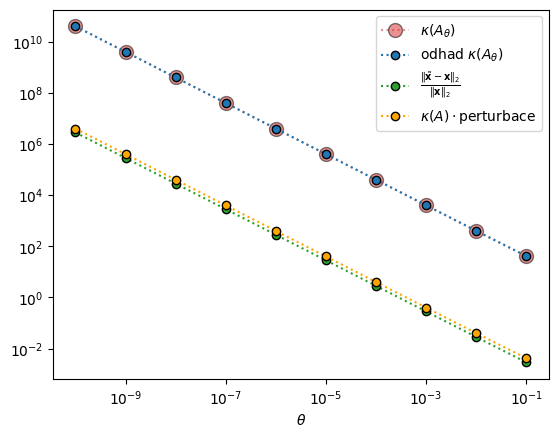

### Úloha A3: Aplikace

Vezmeme si 2 konkrétní systémy $(\star)$ - pro jeden z nich bude matice $A$ SPD a pro druhý bude ne-normální (tj. $A^TA \neq AA^T$) - a vykreslíme si vývoj chyby $\mathbf{e}_k$ měřené různými normami.

Nevezmeme si "uměle zákeřné problémy", ale systémy $(\star)$ ze zjednodušené, ale reálné aplikace - jeden problém odpovídá "[difuzi](https://en.wikipedia.org/wiki/Diffusion)" (česky "sálání") a druhý "[advekci](https://en.wikipedia.org/wiki/Advection)-difuzi" (česky "proudění-sálání"). Detaily jsou nastíněné v anotaci funkcí `get_ProblemDifuze(n)` a `get_ProblemAdvekceDifuze(n)`, které pro daný integer $n$ vrací matici a pravou stranu a tím definuje systémy

$$
A_{diff} \mathbf{x}_{diff} =  \mathbf{b}_{diff}
\quad \mathrm{a} \quad
A_{advdiff} \mathbf{x}_{advdiff} =  \mathbf{b}_{adv diff}.
$$

Matice $A_{diff}$ je SPD a matice $A_{advdiff}$ je nenormální pro libovolné $n>2$. Po spuštění následujících dvou buněk s kódem se vykreslí vývoj chyby $\| \mathbf{e}_{k} \|_{1,2,ïnfty}$ jako funkce počtu iterací $k$ v *semi-logaritmickému měřítku v proměnné $y$* (tzn. přesně jako v Úloze 2 výše, viz [`plt.semilogy()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.semilogy.html)).


Na základě přednášky víme, že konvergenci stacionárních iteračních metod lze zaručit splněním
$$ \rho(I-M^{-1}A) < 1 \qquad \mathrm{nebo} \qquad \|| I-M^{-1}A \|| < 1 $$
pro libovolnou maticovou normu splňující $\|| X\mathbf{v} \|| \leq \|| X \|| \cdot \|| \mathbf{v} \||$, přičemž podmínka vpravo na normu iterační matice je vždy silnější než podmínka vlevo na spektrální poloměr iterační matice, ale v praxi často snáze ověřitelná (např. věta o konvergenci Jacobiho metody pro ostře diagonálně dominantní matice).

My se podíváme na to o kolik může být podmínka vpravo slinější než ta vlevo a jaký to může mít vliv na konvergenci.

---
**Kódění** : Budeme pracovat v buňce vykreslující vývoj chyby Jacobiho a Gauss-Seidelovy metody, konkrétně v prostřední části, začínající příkazem `ChciPracovatsNormamaAPolomerama = False`.

  - doplňte kód tak, aby "počítal, to co má", například
    - `IteracniMatice_Diff_Jac` by měla být iterační matice pro Jacobiho metodu použitou na problém s maticí $A_{diff}$,
    - `SpektrPolomer_AdvDiff_Jac` by mělo být číslo odpovídající spektrálnímu poloměru iterační matice Jacobiho metody použité na problém s maticí $A_{advdiff}$,
    - `Norma1_Diff_GS` odpovídá $1$-normě iterační matice pro Gauss-Seidel metodu použitou na problém s maticí $A_{diff}$,
    - `Norma2_Diff_GS` odpovídá $2$-normě iterační matice pro Gauss-Seidel metodu použitou na problém s maticí $A_{diff}$,
    - `NormaInf_Diff_GS` odpovídá $\infty$-normě iterační matice pro Gauss-Seidel metodu použitou na problém s maticí $A_{diff}$.

    - Funkce pro výpočet vlastních čísel matice je [`np.linalg.eigvals()`](https://numpy.org/doc/2.0/reference/generated/numpy.linalg.eigvals.html).

    - Funkce pro výpočet normy matice je [`np.linalg.norm()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html). Je důležité upřesnit "typ normy", to se dělá skrze druhý input `ord` - například `np.linalg.norm( X , ord=2 )` spočítá 2-normu matice $X$.

    - Funkce pro nalezení největšího prvku pole je [`np.max()`](https://numpy.org/doc/stable/reference/generated/numpy.max.html).    
    
  - <details>
    <summary>Chci <font color="red"><b>hint</b></font></summary>
  Iterační matice stacionární metody odpovídající štěpení $A=M-N$ je matice $I-M^{-1}A$.
  </details>

  - předefinujte `ChciPracovatsNormamaAPolomerama` z `False` na `True`. Na základě Úlohy A1 a A2 vysvětlete konvergenci, kterou jsme vykreslili, za použití nově spočtených norem a spektrálních poloměrů (měly by se vám objevit v rozích grafů).

---

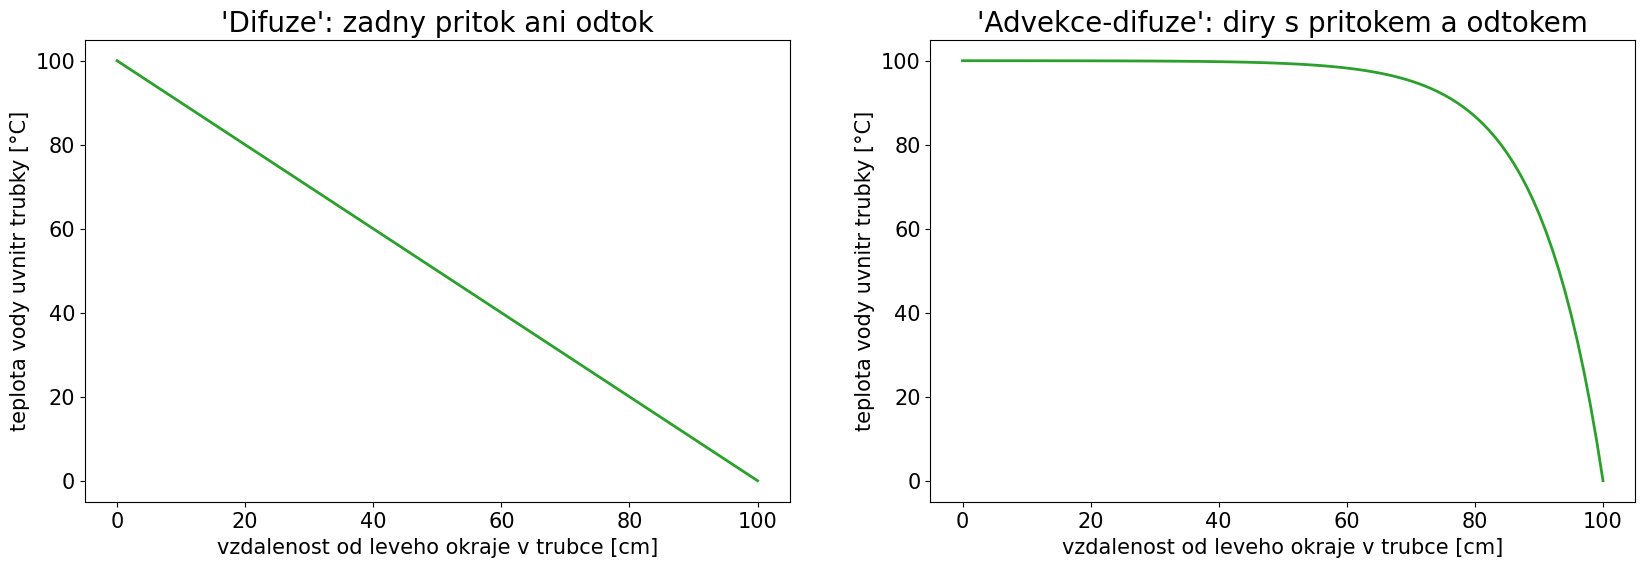

In [ ]:
##################### Je nutne tuto bunku spustit, neni nutne (a asi ani vhodne) v ni cokoliv psat/menit
##################### Anotaci funkci si muzete precist (jinak bych se s tim nepsal), ale neni stezejni k pokracovani cvika
##################### Lze v klidu pokracovat s tim, ze mame preddefinovane 2 funkce, ktere nam kazda vraceji matici a pravou stranu, ktere "nejsou uplne vycucane z prstu"

def get_ProblemDifuze(n):
  '''
  Vrati nam matici "A" a vektor prave strany "b" t., ze reseni aproximuje "asymptoticke rozlozeni teploty vody v trubce" - pro zajemce, odpovida to nasledujicimu set-upu:
    - Predstavime si 1D trubku, ktere je plna vody a je na obou koncich uzavrena.
    - Na levy okraj trubky priplacneme ohrivak o teplote 100 °C.
    - Na pravy okraj trubky priplacneme led o teplote 0 °C.
    - Budeme predpokladat, ze mimo okraju trubka perfektne izoluje, tj. jedine tepelne zdroje jsou na okrajich. Take budeme predpokladat, ze nam led nikdy neroztaje.
    - Otazka, kterou si muzeme polozit : kdyz nechame trubku dostatecne dlouho v klidu, jak bude vypadat teplota vody v trubce?
    - Nejjednodussi zpusob aproximace vysledneho teplotniho profilu vody v trubce vede na problem Ax=b
  Proc ma "A" a "b" vypadat zrovna takhle se muzete dozvedet napr. v predmetu "NMMA338: Numerické řešení parciálních diferenciálních rovnic".
  '''
  h = 1/(n+1)
  A = 1/h**2 * ( 2*np.diag(np.ones(n),0) - np.diag(np.ones(n-1),-1) - np.diag(np.ones(n-1),1) )
  b = np.zeros(n); LeftDirichletBC = 100; b[0] = 1/h**2 * LeftDirichletBC
  return A, b

def get_ProblemAdvekceDifuze(n,adv_coeff=2.15):
  '''
  Vrati nam matici "A" a vektor prave strany "b" t., ze reseni aproximuje "asymptoticke rozlozeni teploty vody v trubce" - pro zajemce, odpovida to nasledujicimu set-upu:
    - Stejne jako vyse :
      - Predstavime si 1D trubku, ktere je plna vody a je na obou koncich uzavrena.
      - Na levy okraj trubky priplacneme ohrivak o teplote 100 °C.
      - Na pravy okraj trubky priplacneme led o teplote 0 °C.
      - Budeme predpokladat, ze mimo okraju trubka perfektne izoluje, tj. jedine tepelne zdroje jsou na okrajich. Take budeme predpokladat, ze nam led nikdy neroztaje.
    - Navic si situaci udelame zajimavejsi tim, ze
      - Vyvrtame v obou koncich trubky diru.
      - Levym okrajem nechame do trubky proudit vodu o teplote 100 °C (predehratou).
      - Pravym okrajem nechame z trubky vytekat vodu o teplote 0 °C (ochlazenou v dusledku ledu na zbytkupraveho okraje).
      - "Silu proudu" zleva doprava budeme kontrolovat koeficientem "adv_coeff" - mel by byt v intervalu [0,+nekonecno) - cim vyssi, tim silnejsi proud.
      - Zanedbame turbulence/viry vodniho toku uvnitr trubky.
    - Prirozena intuice je, ze
      - pokud "adv_coeff=0", pak dostaneme zpatky "ProblemDifuze".
      - pokud "adv_coeff>>0", pak nam silny proud nazene teplo z leveho okraje i dost blizko chlazeni na pravem okraji.

    - Otazka, kterou si muzeme polozit : kdyz nechame trubku dostatecne dlouho v klidu, jak bude vypadat teplota vody v trubce?
      - pokud "adv_coeff=0", pak ocekavame, ze se teplota rovnomerne rozprostre mezi 100 °C a 0 °C podel cele trubky.
      - pokud "adv_coeff>>0", pak ocekavame, ze se teplota bude blizko 100 °C i vyrazne dale od leveho konce, protoze ji tam proud neustale unasi a pravy konec ji "nestiha uchladit".
    - Nejjednodussi zpusob aproximace vysledneho teplotniho profilu vody v trubce vede na problem Ax=b
  Proc ma "A" a "b" vypadat zrovna takhle se muzete dozvedet napr. v predmetu "NMMA338: Úvod do parciálních diferenciálních rovnic".
  '''
  h = 1/(n+1); adv_coeff = adv_coeff/h # "adv_coeff ~ 1/DiscretePeclet"
  A = 1/h**2 * ( 2*np.diag(np.ones(n),0) - np.diag(np.ones(n-1),-1) - np.diag(np.ones(n-1),1) )  +  adv_coeff * 1/(2*h) * ( np.diag(np.ones(n-1),1) - np.diag(np.ones(n-1),-1) )
  b = np.zeros(n); LeftDirichletBC = 100; b[0] = 1/h**2 * LeftDirichletBC  + adv_coeff * 1/(2*h) * LeftDirichletBC
  return A, b


##################### Demo
n=100 #parametr urcujici "presnost aproximace". Cim vetsi, tim lepsi, ale pro n>>1000 to bude bezet netrivialne dlouho

### sestavime A, b pro problem "difuze"
A,b = get_ProblemDifuze(n); u_diff = np.linalg.solve(A,b); x = np.linspace(0,100,n+2); u_diffBC = np.concatenate( (np.array([100]), u_diff ,np.array([0])) )
### sestavime A, b pro problem "advekce-difuze"
adv_coeff = 1/10 # cislo z intervalu (0,+infty) -> pro "adv_coeff >> 2" ocekavame numerickou nestabilitu
A,b = get_ProblemAdvekceDifuze(n,adv_coeff); u_advdiff = np.linalg.solve(A,b); u_advdiffBC = np.concatenate( (np.array([100]), u_advdiff ,np.array([0])) )

fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(20,6))

ax1.plot(x, u_diffBC, '-', lw=2, c='tab:green')
ax1.yaxis.set_tick_params(labelsize=15); ax1.xaxis.set_tick_params(labelsize=15)
ax1.set_ylabel('teplota vody uvnitr trubky [°C]',fontsize=15); ax1.set_xlabel('vzdalenost od leveho okraje v trubce [cm]',fontsize=15); ax1.set_title(r"'Difuze': zadny pritok ani odtok", fontsize=20)
#ax1.set_ylim( 0.3*min( np.min(Chyby_AdvDiff_GS_Inf) , np.min(Chyby_AdvDiff_Jac_Inf) ), 3*max( np.max(Chyby_AdvDiff_GS_Inf) , np.max(Chyby_AdvDiff_Jac_Inf) ))

ax2.plot(x, u_advdiffBC, '-', lw=2, c='tab:green')
ax2.yaxis.set_tick_params(labelsize=15); ax2.xaxis.set_tick_params(labelsize=15)
ax2.set_ylabel('teplota vody uvnitr trubky [°C]',fontsize=15); ax2.set_xlabel('vzdalenost od leveho okraje v trubce [cm]',fontsize=15); ax2.set_title(r"'Advekce-difuze': diry s pritokem a odtokem", fontsize=20)
plt.show()

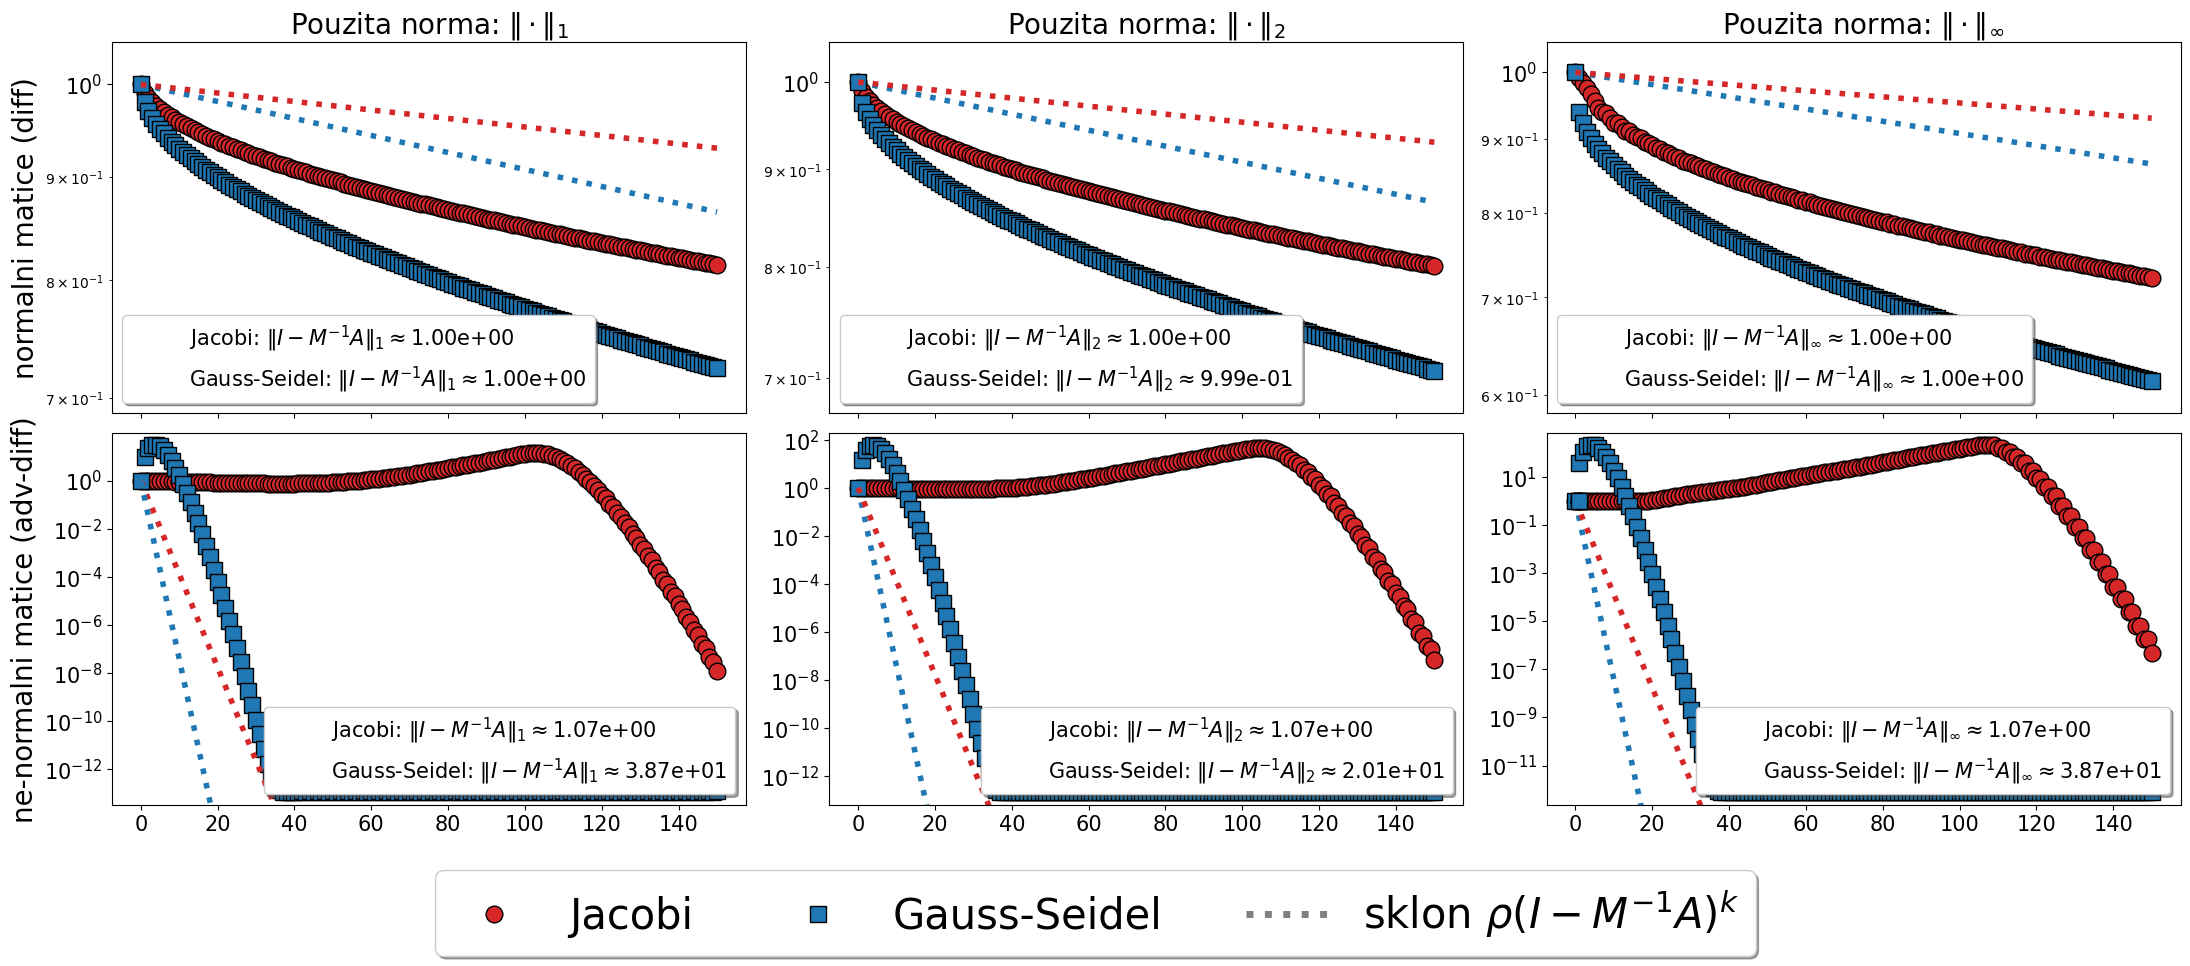

In [ ]:
######################################################################################################################################################
### vypocet Jacobi & Gauss-Seidel iteraci pro nase dva systemy - zacatek
pocetiter = 150 # pocet iteraci provedenych Jacobiho a Gauss-Seidelem
n = 100; initguess = np.random.rand(n);

### sestavime A, b pro problem "difuze"
A_diff,b_diff = get_ProblemDifuze(n); u_diff = np.linalg.solve(A_diff,b_diff);
#experimenty s Jacobiho metodou
Aproximace_Diff_Jac = JacobihoMetoda(A_diff, b_diff, initguess, pocetiter)
Chyby_Diff_Jac_1 = np.linalg.norm(Aproximace_Diff_Jac - u_diff, axis=1, ord=1) / np.linalg.norm(Aproximace_Diff_Jac[0,:] - u_diff, ord=1)
Chyby_Diff_Jac_2 = np.linalg.norm(Aproximace_Diff_Jac - u_diff, axis=1, ord=2) / np.linalg.norm(Aproximace_Diff_Jac[0,:] - u_diff, ord=2)
Chyby_Diff_Jac_Inf = np.linalg.norm(Aproximace_Diff_Jac - u_diff, axis=1, ord=np.inf)  / np.linalg.norm(Aproximace_Diff_Jac[0,:] - u_diff, ord=np.inf)
#experimenty s Gauss-Seidel metodou
Aproximace_Diff_GS = GaussSeidelMetoda(A_diff, b_diff, initguess, pocetiter)
Chyby_Diff_GS_1 = np.linalg.norm(Aproximace_Diff_GS - u_diff, axis=1, ord=1) / np.linalg.norm(Aproximace_Diff_GS[0,:] - u_diff, ord=1)
Chyby_Diff_GS_2 = np.linalg.norm(Aproximace_Diff_GS - u_diff, axis=1, ord=2) / np.linalg.norm(Aproximace_Diff_GS[0,:] - u_diff, ord=2)
Chyby_Diff_GS_Inf = np.linalg.norm(Aproximace_Diff_GS - u_diff, axis=1, ord=np.inf) / np.linalg.norm(Aproximace_Diff_GS[0,:] - u_diff, ord=np.inf)


### sestavime A, b pro problem "advekce-difuze"
A_advdiff,b_advdiff = get_ProblemAdvekceDifuze(n); u_advdiff = np.linalg.solve(A_advdiff,b_advdiff);
#experimenty s Jacobiho metodou
Aproximace_AdvDiff_Jac = JacobihoMetoda(A_advdiff, b_advdiff, initguess, pocetiter)
Chyby_AdvDiff_Jac_1 = np.linalg.norm(Aproximace_AdvDiff_Jac - u_advdiff, axis=1, ord=1) / np.linalg.norm(Aproximace_AdvDiff_Jac[0,:] - u_advdiff,ord=1)
Chyby_AdvDiff_Jac_2 = np.linalg.norm(Aproximace_AdvDiff_Jac - u_advdiff, axis=1, ord=2) / np.linalg.norm(Aproximace_AdvDiff_Jac[0,:] - u_advdiff, ord=2)
Chyby_AdvDiff_Jac_Inf = np.linalg.norm(Aproximace_AdvDiff_Jac - u_advdiff, axis=1, ord=np.inf) / np.linalg.norm(Aproximace_AdvDiff_Jac[0,:] - u_advdiff, ord=np.inf)
#experimenty s Gauss-Seidel metodou
Aproximace_AdvDiff_GS = GaussSeidelMetoda(A_advdiff, b_advdiff, initguess, pocetiter)
Chyby_AdvDiff_GS_1 = np.linalg.norm(Aproximace_AdvDiff_GS - u_advdiff, axis=1, ord=1) / np.linalg.norm(Aproximace_AdvDiff_GS[0,:] - u_advdiff, ord=1)
Chyby_AdvDiff_GS_2 = np.linalg.norm(Aproximace_AdvDiff_GS - u_advdiff, axis=1, ord=2) / np.linalg.norm(Aproximace_AdvDiff_GS[0,:] - u_advdiff, ord=2)
Chyby_AdvDiff_GS_Inf = np.linalg.norm(Aproximace_AdvDiff_GS - u_advdiff, axis=1, ord=np.inf) / np.linalg.norm(Aproximace_AdvDiff_GS[0,:] - u_advdiff, ord=np.inf)
### vypocet Jacobi & Gauss-Seidel iteraci pro nase dva systemy - konec
######################################################################################################################################################






######################################################################################################################################################
### predikce konvergence Jacobi & Gauss-Seidel iteraci - zacatek
ChciPracovatsNormamaAPolomerama = False ### pokud "True", pak kod vykresluje i odhady konvergence, ktere jsme videli an prednasce

if ChciPracovatsNormamaAPolomerama:

  ### vypocty pro problem "difuze" - pracujeme s matici A = A_diff
  A = A_diff
  # Jacobiho metoda
  M =
  N =
  IteracniMatice_Diff_Jac =
  SpektrPolomer_Diff_Jac =
  Norma1_Diff_Jac =
  Norma2_Diff_Jac =
  NormaInf_Diff_Jac =
  # Gauss-Seidel metoda
  SpektrPolomer_Diff_GS =
  Norma1_Diff_GS =
  Norma2_Diff_GS =
  NormaInf_Diff_GS =


  ### vypocty pro problem "advekce-difuze" - pracujeme s matici A = A_advdiff
  A = A_advdiff
  # Jacobiho metoda
  SpektrPolomer_AdvDiff_Jac
  Norma1_AdvDiff_Jac
  Norma2_AdvDiff_Jac
  NormaInf_AdvDiff_Jac
  # Gauss-Seidel metoda
  SpektrPolomer_AdvDiff_GS
  Norma1_AdvDiff_GS
  Norma2_AdvDiff_GS
  NormaInf_AdvDiff_GS
### predikce konvergence Jacobi & Gauss-Seidel iteraci - konec
######################################################################################################################################################



######################################################################################################################################################
### vykreslovani zacatek
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=False, figsize=(22,9))
iterace = np.arange(0,pocetiter+1,1, dtype=np.float64)

ax1.semilogy(Chyby_Diff_Jac_1, 'o', lw=0, markerfacecolor='tab:red', markeredgecolor='k', ms=12)
ax1.semilogy(Chyby_Diff_GS_1, 's', lw=0, markerfacecolor='tab:blue', markeredgecolor='k', ms=12)
ax1.yaxis.set_tick_params(labelsize=15); ax1.xaxis.set_tick_params(labelsize=15); ax1.set_title(r"Pouzita norma: $\| \cdot \|_{1}$", fontsize=20)
ax1.set_ylim( 0.95*min( np.min(Chyby_Diff_GS_1) , np.min(Chyby_Diff_Jac_1) ), 1.05*max( np.max(Chyby_Diff_GS_1) , np.max(Chyby_Diff_Jac_1) ))
ax1.set_ylabel(r"normalni matice (diff)", fontsize=20)
if ChciPracovatsNormamaAPolomerama:
  ax1.semilogy(SpektrPolomer_Diff_GS**iterace, ':', color='tab:blue', lw=4)
  ax1.semilogy(SpektrPolomer_Diff_Jac**iterace, ':', color='tab:red', lw=4)
  all_handles = []; all_labels = []; line1, = ax1.plot([10,11],[0.9,0.8], '-', lw=0, color='white');
  all_handles.extend([line1,line1]); all_labels.extend([r'Jacobi: $\|I-M^{-1}A\|_{1} \approx $' + '{:.2e}'.format(Norma1_Diff_Jac), r'Gauss-Seidel: $\|I-M^{-1}A\|_{1} \approx $' + '{:.2e}'.format(Norma1_Diff_GS)])
  ax1.legend(all_handles, all_labels, loc='lower left', fancybox=True, shadow=True, ncol=1, fontsize=15)

ax2.semilogy(Chyby_Diff_Jac_2, 'o', lw=0, markerfacecolor='tab:red', markeredgecolor='k', ms=12)
ax2.semilogy(Chyby_Diff_GS_2, 's', lw=0, markerfacecolor='tab:blue', markeredgecolor='k', ms=12)
ax2.yaxis.set_tick_params(labelsize=15); ax2.xaxis.set_tick_params(labelsize=15); ax2.set_title(r"Pouzita norma: $\| \cdot \|_{2}$", fontsize=20)
ax2.set_ylim( 0.95*min( np.min(Chyby_Diff_GS_2) , np.min(Chyby_Diff_Jac_2) ), 1.05*max( np.max(Chyby_Diff_GS_2) , np.max(Chyby_Diff_Jac_2) ))
if ChciPracovatsNormamaAPolomerama:
  ax2.semilogy(SpektrPolomer_Diff_GS**iterace, ':', color='tab:blue', lw=4)
  ax2.semilogy(SpektrPolomer_Diff_Jac**iterace, ':', color='tab:red', lw=4)
  all_handles = []; all_labels = []; line1, = ax2.plot([10,11],[0.9,0.8], '-', lw=0, color='white');
  all_handles.extend([line1,line1]); all_labels.extend([r'Jacobi: $\|I-M^{-1}A\|_{2} \approx $' + '{:.2e}'.format(Norma2_Diff_Jac), r'Gauss-Seidel: $\|I-M^{-1}A\|_{2} \approx $' + '{:.2e}'.format(Norma2_Diff_GS)])
  ax2.legend(all_handles, all_labels, loc='lower left', fancybox=True, shadow=True, ncol=1, fontsize=15)

ax3.semilogy(Chyby_Diff_Jac_Inf, 'o', lw=0, markerfacecolor='tab:red', markeredgecolor='k', ms=12)
ax3.semilogy(Chyby_Diff_GS_Inf, 's', lw=0, markerfacecolor='tab:blue', markeredgecolor='k', ms=12)
ax3.yaxis.set_tick_params(labelsize=15); ax3.xaxis.set_tick_params(labelsize=15); ax3.set_title(r"Pouzita norma: $\| \cdot \|_{\infty}$", fontsize=20)
ax3.set_ylim( 0.95*min( np.min(Chyby_Diff_GS_Inf) , np.min(Chyby_Diff_Jac_Inf) ), 1.05*max( np.max(Chyby_Diff_GS_Inf) , np.max(Chyby_Diff_Jac_Inf) ))
if ChciPracovatsNormamaAPolomerama:
  ax3.semilogy(SpektrPolomer_Diff_GS**iterace, ':', color='tab:blue', lw=4)
  ax3.semilogy(SpektrPolomer_Diff_Jac**iterace, ':', color='tab:red', lw=4)
  all_handles = []; all_labels = []; line1, = ax3.plot([10,11],[0.9,0.8], '-', lw=0, color='white');
  all_handles.extend([line1,line1]); all_labels.extend([r'Jacobi: $\|I-M^{-1}A\|_{\infty} \approx $' + '{:.2e}'.format(NormaInf_Diff_Jac), r'Gauss-Seidel: $\|I-M^{-1}A\|_{\infty} \approx $' + '{:.2e}'.format(NormaInf_Diff_GS)])
  ax3.legend(all_handles, all_labels, loc='lower left', fancybox=True, shadow=True, ncol=1, fontsize=15)


ax4.semilogy(Chyby_AdvDiff_Jac_1, 'o', lw=0, markerfacecolor='tab:red', markeredgecolor='k', ms=12)
ax4.semilogy(Chyby_AdvDiff_GS_1, 's', lw=0, markerfacecolor='tab:blue', markeredgecolor='k', ms=12)
ax4.yaxis.set_tick_params(labelsize=15); ax4.xaxis.set_tick_params(labelsize=15)
ax4.set_ylim( 0.3*min( np.min(Chyby_AdvDiff_GS_1) , np.min(Chyby_AdvDiff_Jac_1) ), 3*max( np.max(Chyby_AdvDiff_GS_1) , np.max(Chyby_AdvDiff_Jac_1) ))
ax4.set_ylabel(r"ne-normalni matice (adv-diff)", fontsize=20)
if ChciPracovatsNormamaAPolomerama:
  ax4.semilogy(SpektrPolomer_AdvDiff_Jac**iterace, ':', color='tab:red', lw=4)
  ax4.semilogy(SpektrPolomer_AdvDiff_GS**iterace, ':', color='tab:blue', lw=4)
  all_handles = []; all_labels = []; line1, = ax4.plot([10,11],[0.9,0.8], '-', lw=0, color='white');
  all_handles.extend([line1,line1]); all_labels.extend([r'Jacobi: $\|I-M^{-1}A\|_{1} \approx $' + '{:.2e}'.format(Norma1_AdvDiff_Jac), r'Gauss-Seidel: $\|I-M^{-1}A\|_{1} \approx $' + '{:.2e}'.format(Norma1_AdvDiff_GS)])
  ax4.legend(all_handles, all_labels, loc='lower right', fancybox=True, shadow=True, ncol=1, fontsize=15)

ax5.semilogy(Chyby_AdvDiff_Jac_2, 'o', lw=0, markerfacecolor='tab:red', markeredgecolor='k', ms=12)
ax5.semilogy(Chyby_AdvDiff_GS_2, 's', lw=0, markerfacecolor='tab:blue', markeredgecolor='k', ms=12)
ax5.yaxis.set_tick_params(labelsize=15); ax5.xaxis.set_tick_params(labelsize=15)
ax5.set_ylim( 0.3*min( np.min(Chyby_AdvDiff_GS_2) , np.min(Chyby_AdvDiff_Jac_2) ), 3*max( np.max(Chyby_AdvDiff_GS_2) , np.max(Chyby_AdvDiff_Jac_2) ))
if ChciPracovatsNormamaAPolomerama:
  ax5.semilogy(SpektrPolomer_AdvDiff_GS**iterace, ':', color='tab:blue', lw=4)
  ax5.semilogy(SpektrPolomer_AdvDiff_Jac**iterace, ':', color='tab:red', lw=4)
  all_handles = []; all_labels = []; line1, = ax5.plot([10,11],[0.9,0.8], '-', lw=0, color='white');
  all_handles.extend([line1,line1]); all_labels.extend([r'Jacobi: $\|I-M^{-1}A\|_{2} \approx $' + '{:.2e}'.format(Norma2_AdvDiff_Jac), r'Gauss-Seidel: $\|I-M^{-1}A\|_{2} \approx $' + '{:.2e}'.format(Norma2_AdvDiff_GS)])
  ax5.legend(all_handles, all_labels, loc='lower right', fancybox=True, shadow=True, ncol=1, fontsize=15)

ax6.semilogy(Chyby_AdvDiff_Jac_Inf, 'o', lw=0, markerfacecolor='tab:red', markeredgecolor='k', ms=12)
ax6.semilogy(Chyby_AdvDiff_GS_Inf, 's', lw=0, markerfacecolor='tab:blue', markeredgecolor='k', ms=12)
ax6.yaxis.set_tick_params(labelsize=15); ax6.xaxis.set_tick_params(labelsize=15)
ax6.set_ylim( 0.3*min( np.min(Chyby_AdvDiff_GS_Inf) , np.min(Chyby_AdvDiff_Jac_Inf) ), 3*max( np.max(Chyby_AdvDiff_GS_Inf) , np.max(Chyby_AdvDiff_Jac_Inf) ))
if ChciPracovatsNormamaAPolomerama:
  ax6.semilogy(SpektrPolomer_AdvDiff_GS**iterace, ':', color='tab:blue', lw=4)
  ax6.semilogy(SpektrPolomer_AdvDiff_Jac**iterace, ':', color='tab:red', lw=4)
  all_handles = []; all_labels = []; line1, = ax6.plot([10,11],[0.9,0.8], '-', lw=0, color='white');
  all_handles.extend([line1,line1]); all_labels.extend([r'Jacobi: $\|I-M^{-1}A\|_{\infty} \approx $' + '{:.2e}'.format(NormaInf_AdvDiff_Jac), r'Gauss-Seidel: $\|I-M^{-1}A\|_{\infty} \approx $' + '{:.2e}'.format(NormaInf_AdvDiff_GS)])
  ax6.legend(all_handles, all_labels, loc='lower right', fancybox=True, shadow=True, ncol=1, fontsize=15)


if ChciPracovatsNormamaAPolomerama:
  ax = plt.gca(); fig = plt.gcf(); all_handles = []; all_labels = []
  line1, = ax.plot([1,1],[1,1], '-o', lw=0, markerfacecolor='tab:red', markeredgecolor='k', ms=12); line2, = ax.plot([1,1],[1,1], '-s', lw=0, markerfacecolor='tab:blue', markeredgecolor='k', ms=12)
  line3, = ax.plot([100,101],[1e-5,1e-7], ':', lw=5, color='tab:gray'); line3b, = ax.plot([100,101],[1e-5,1e-7], '-', lw=10, color='white')
  all_handles.extend([line1, line2, line3])
  all_labels.extend([r'Jacobi', r'Gauss-Seidel', r'sklon $\rho(I - M^{-1}A)^k$'])
  fig.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), fancybox=True, shadow=True, ncol=3, fontsize=30)
  plt.tight_layout(rect=[0, 0.05, 1, 1])
else:
  ax = plt.gca(); fig = plt.gcf(); all_handles = []; all_labels = []
  line1, = ax.plot([1,1],[1,1], '-o', lw=0, markerfacecolor='tab:red', markeredgecolor='k', ms=12); line2, = ax.plot([1,1],[1,1], '-s', lw=0, markerfacecolor='tab:blue', markeredgecolor='k', ms=12)
  line3, = ax.plot([100,101],[1e-5,1e-7], ':', lw=5, color='tab:gray'); line3b, = ax.plot([100,101],[1e-5,1e-7], '-', lw=10, color='white')
  all_handles.extend([line1, line2])
  all_labels.extend([r'Jacobi', r'Gauss-Seidel'])
  fig.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), fancybox=True, shadow=True, ncol=3, fontsize=30)
  plt.tight_layout(rect=[0, 0.05, 1, 1])

plt.show()
### vykreslovani konec
######################################################################################################################################################

## Část B: Stacionární metody & polynomy

Stacionární matody byly populární druhé polovině minulého století, ale jejich popularita začala ustupovat ve prospěch tzv. [metod Krylovovských prostorů](https://en.wikipedia.org/wiki/Krylov_subspace#Existing_methods) - o Krylovovské prostory ještě potkáme v rámci problému vlastních čísel.

My se podíváme právě na přechod od stacionárních metod ke Krylovovským pro nejjednoduší stacionární metodu - [Richardsonovu metodu](https://en.wikipedia.org/wiki/Modified_Richardson_iteration), která odpovídá volbě $M=I$, $N = I-A$ a je tedy definována iterací
$$ \mathbf{x}_{k} = (I-A)\mathbf{x}_{k-1} +\mathbf{b} = \mathbf{x}_{k-1} + (\mathbf{b} - A\mathbf{x}_{k-1}).$$

Zároveň připomeneme, že pro matice umíme definovat *polynomy matic* pro libovlnou čtvercovou matici - například pro $X\in \mathbb{R}^{n\times n}$ a pro polynom $p(t) := t^2-4t+3 = (t-3)(t-1)$ platí
$$ p(X) = X^2-4X+2I_n = (X-3I_n)(X-I_n). $$

### Úloha B1 - Richardsonova metoda & Krylov

---
**Tužka a papír**:

  - na základě rekurence pro aproximace $\mathbf{x}_k$ Richardsonovy metody odvoďte rekurenci pro *rezidua* Richardsonovy metody.
  
    <details>
    <summary>Chci <font color="red"><b>hint</b></font></summary>
      Pro aproximaci $\mathbf{x}_k$ řešení systému $A\mathbf{x} = \mathbf{b}$ je reziduum definováno jako $A(\mathbf{x}-\mathbf{x}_k) = \mathbf{b} - A\mathbf{x}_k$, kde $\mathbf{x}$ je přesné řešení.
    </details>

  - pomocí této rekurence najděte reálný polynom $q_2(t)$, pro který platí $\mathbf{r}_2 = q_2(I-A) \mathbf{r}_0$. Následně zobecněte pro $k$-té reziduum a najděte příslušný $q_k(t)$ stupně nejvýše $k$.
  
    <details>
    <summary>Chci <font color="red"><b>hint</b></font></summary>
      Na základě rekurence si rozepište $\mathbf{r}_k$ pomocí $A$ a $\mathbf{r}_0$.
    </details>

  - najděte reálný polynom $p_k(t)$ stupně nejvýše $k$, pro který platí $\mathbf{r}_k = p_k(A) \mathbf{r}_0$.

  - ukažte ekvivalenci následujících dvou bodů:
    - $\mathbf{r}_k = p_k(A) \mathbf{r}_0$ pro nějaký reálný polynom $p_k(t)$ stupně nejvýše $k$ takový, že $p_k(0) = 1$,
    - $\mathbf{r}_k \in \mathbf{r}_0 + A \cdot \mathrm{span} \left( \mathbf{r}_0, A\mathbf{r}_0, \dotsc , A^{k-1}\mathbf{r}_0  \right)$.
  
    <details>
    <summary>Chci <font color="red"><b>hint</b></font></summary>
      Ukžte, že libovolný polynom $p_k$ stupně nejvýše $k$, pro který platí $p_k(0)=1$, lze zapsat jako $p_k(t)=1 + t\cdot \tilde{p}_{k-1}(t)$ pro nějaký polynom $\tilde{p}_{k-1}(t)$ stupně nejvýše $k-1$.
    </details>

----

Jinými slovy, Richardsonova metoda konstruuje aproximace $\mathbf{x}_k$ tak, že rezidua $\mathbf{r}_k$ leží v prostoru

$$ \mathbf{r}_0 + A \cdot \underbrace{ \, \mathrm{span} \left( \mathbf{r}_0, A\mathbf{r}_0, \dotsc , A^{k-1}\mathbf{r}_0  \right) \, }_{=: \, \mathcal{K}_{k}(A,\mathbf{r}_0)} \, \equiv \,  \mathbf{r}_0 + A \cdot \mathcal{K}_{k}(A,\mathbf{r}_0) ,$$

který je definován pomocí $\mathcal{K}_{k}(A,\mathbf{r}_0) $, tzv. [$k$-tého Krylovova podprostoru příslušejícího $A$ a $\mathbf{r}_0$](https://en.wikipedia.org/wiki/Krylov_subspace).


Iterační metody, které jsou dnes asi nejvíce používané fungují jako "vylepšováky" tohoto postupu. Volí $\mathbf{x}_k$ tak, aby stále platilo

$$\mathbf{r}_k \in  \mathbf{r}_0 + A \cdot \mathcal{K}_{k}(A,\mathbf{r}_0),$$

protože se dá ukázat, že to je z výpočetního hlediska vhodné/přirozené, ale snaží se "v jistém smyslu optimalizovat aproximaci $\mathbf{x}_k$" - například minimalizovat $\|\mathbf{r}_k\|$. Jinými slovy, nevolí vždy "stejný polynom $p_k(t)$", ale adaptují ho v každé iteraci na základě předešlých iterací. Těmto metodám se říká metody Krylovovských prostorů a vícew se o nich dozvíte během 3. ročníku, například v rámci předmětu [NMNM331: Analýza maticových výpočtů 1](https://is.cuni.cz/studium/predmety/index.php?do=predmet&kod=NMNM331).



### ZÚ - Krylov pro obecné štěpení

---
**Tužka a papír**:

  - na základě rekurence pro chybu $\mathbf{e}_k = \mathbf{x} - \mathbf{x}_k$ obecné stacionární metody založené na štěpení $A=M-N$ (máme ji na začátku google-sheetu) odvoďte rekurenci pro *rezidua*.

  - analogicky k postupu v Úloze B1 vyjádřete $k$-té reziduum $\mathbf{r}_k$ jako nějaký reálný polynom $p_k(t)$ stupně nejvýše $k$ a splňující $p_k(0)=1$ v nějaké matici $X$ aplikovaný na počáteční reziduum, tj. najděte polynom $p_k(t)$ (stupně nejvýše $k$) a matici $X$ takové, že platí $\mathbf{r}_k = p_k(X) \mathbf{r}_0$ a zároveň $p_k(0)=1$.

  - s jakým Krylovovským podprostorem takto implicitně pracujeme?

----

## [Kvíz](https://forms.gle/ceFpN9y3FC2tMLrC7)